<a href="https://colab.research.google.com/github/kim-jason/calib-challenge/blob/main/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# comma.ai's Calibration Challenge

References: 

*   https://deepai.org/publication/self-driving-car-steering-angle-prediction-based-on-image-recognition
*   https://arxiv.org/abs/1604.07316v1
*   https://github.com/commaai/calib_challenge 
*   https://github.com/B3WD/comma.ai-calib-challenge

In [ ]:
#Use cell to pull/push to Github

Initialized empty Git repository in /content/.git/
error: refname refs/heads/master not found
fatal: Branch rename failed
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 187 (delta 40), reused 25 (delta 4), pack-reused 104
Receiving objects: 100% (187/187), 366.91 MiB | 34.63 MiB/s, done.
Resolving deltas: 100% (78/78), done.
From https://github.com/kim-jason/calib-challenge
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main


In [ ]:
import cv2
import glob
import tensorflow as tf
import numpy as np
import itertools
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv3D, Conv2D, BatchNormalization, MaxPool2D, MaxPool3D, Flatten, LSTM, Dropout, TimeDistributed, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import resnet_v2
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#Save all video frames as .jpg for the five labeled videos
num_vids = 5 # Harded coded in
for num_vid in range(0, num_vids):
    vid = cv2.VideoCapture('./labeled/{i}.hevc'.format(i = num_vid))
    ret, frame = vid.read()
    num_frames = 0

    while ret:
        if not os.path.exists('./labeled/{i}/'.format(i = num_vid)):
            os.makedirs('./labeled/{i}/'.format(i = num_vid))

        cv2.imwrite('./labeled/{i}/{i}.{num_frames}.jpg'.format(i = num_vid, num_frames = num_frames), frame)
        ret, frame = vid.read()
        num_frames += 1
    print(num_frames)
    vid.release()

print("Finished")

1200
1200
1200
1200
1196
Finished


In [ ]:
#Create dataframe that contains columns of video_number, frame_number, path, pitch, yaw
def atoi(path):
    return int(path) if path.isdigit() else path

def natural_sort(path):
    return [atoi(c) for c in path.split('.')]

frames_df = pd.DataFrame()

for num_image in range(5): 
    temp_df = pd.read_table('./labeled/{i}.txt'.format(i = num_image), header=None, sep=" ", names=["pitch", "yaw"])

    paths = glob.glob("./labeled/{i}/*.jpg".format(i = num_image))
    paths.sort(key=natural_sort)

    temp_df['path'] = paths
    temp_df['video_number'] = num_image
    temp_df['frame_number'] = range(len(paths))

    frames_df = frames_df.append(temp_df)

frames_df = frames_df[['video_number', 'frame_number', 'path', 'pitch', 'yaw']]
frames_df = frames_df.reset_index(drop=True)
display(frames_df)

,video_number,frame_number,path,pitch,yaw
0,0,0,./labeled/0/0.0.jpg,0.033461,0.031492
1,0,1,./labeled/0/0.1.jpg,0.033320,0.031317
2,0,2,./labeled/0/0.2.jpg,0.033264,0.031203
3,0,3,./labeled/0/0.3.jpg,0.033280,0.031227
4,0,4,./labeled/0/0.4.jpg,0.033334,0.030963
...,...,...,...,...,...
5991,4,1191,./labeled/4/4.1191.jpg,0.015155,0.058989
5992,4,1192,./labeled/4/4.1192.jpg,NaN,NaN
5993,4,1193,./labeled/4/4.1193.jpg,NaN,NaN
5994,4,1194,./labeled/4/4.1194.jpg,NaN,NaN


In [ ]:
def plot_data(x, y, title, x_label, y_label, size=(10,3), label=None):
    plt.figure(figsize=size)
    plt.plot(x, y, label=label)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.show()

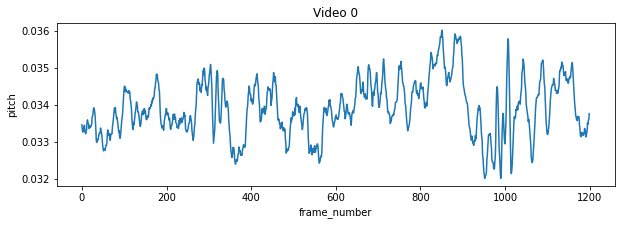

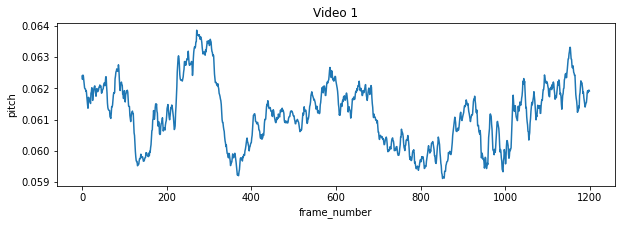

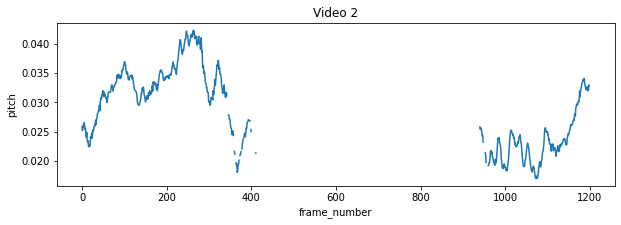

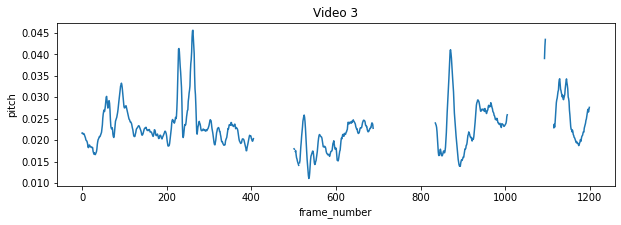

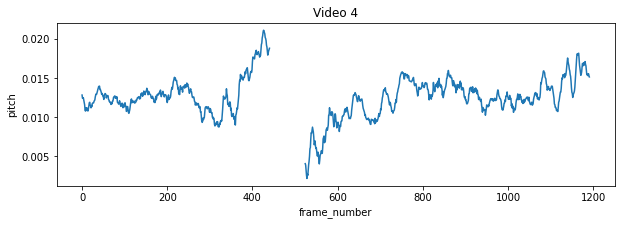

In [ ]:
#Show pitch of all the videos
for video_number, video_data in frames_df.groupby('video_number'):
    plot_data(video_data.frame_number, video_data['pitch'], f"Video {video_number}", 'frame_number', 'pitch')

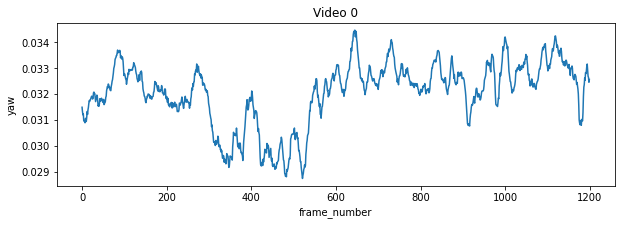

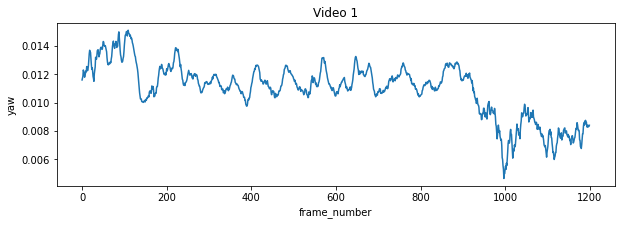

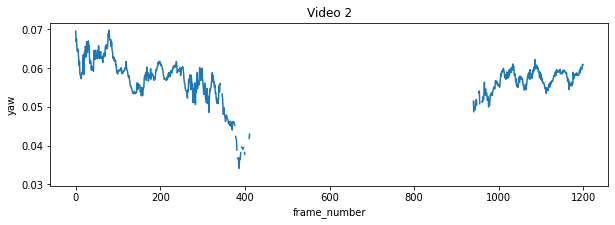

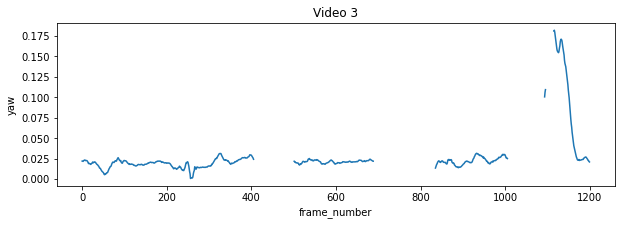

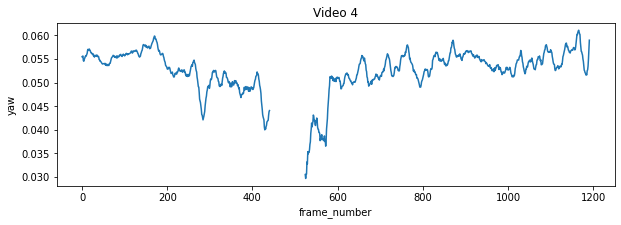

In [ ]:
#Show yaw of all the videos
for video_number, video_data in frames_df.groupby('video_number'):
    plot_data(video_data.frame_number, video_data['yaw'], f"Video {video_number}", 'frame_number', 'yaw')

In [ ]:
#Drop NaN frames
before_frames = frames_df.shape[0]
frames_df = frames_df.dropna()
#frames_df = frames_df.fillna(0)
after_frames = frames_df.shape[0]

print(f"Before number of frames: {before_frames} \nAfter number of frames: {after_frames}")
display(frames_df)

Before number of frames: 5996 
After number of frames: 5019


,video_number,frame_number,path,pitch,yaw
0,0,0,./labeled/0/0.0.jpg,0.033461,0.031492
1,0,1,./labeled/0/0.1.jpg,0.033320,0.031317
2,0,2,./labeled/0/0.2.jpg,0.033264,0.031203
3,0,3,./labeled/0/0.3.jpg,0.033280,0.031227
4,0,4,./labeled/0/0.4.jpg,0.033334,0.030963
...,...,...,...,...,...
5987,4,1187,./labeled/4/4.1187.jpg,0.015339,0.052701
5988,4,1188,./labeled/4/4.1188.jpg,0.015328,0.053488
5989,4,1189,./labeled/4/4.1189.jpg,0.015568,0.055036
5990,4,1190,./labeled/4/4.1190.jpg,0.015318,0.057053


In [ ]:
#Normalize the data
frames_scaler = MinMaxScaler()
frames_df[['pitch', 'yaw']] = frames_scaler.fit_transform(frames_df[['pitch', 'yaw']])

At this point, we now have to split our frames_df into our train_df, val_df, and test_df.

I can see two ways of splitting our frames_df:

1.   Out of all the frames found in our five videos, randomly split them into our train_df (80%), val_df (10%), and test_df (10%)
2.   Save video #4 as our test_df and use the frames from videos #0-3 for our train_df and val_df

In [ ]:
#Method 1: Split frames_df into train set (80%), val set (10%), and test set (10%)
train_df = frames_df.sample(frac=0.90)
test_df = frames_df.drop(train_df.index)

val_df = train_df.sample(frac=0.1)
train_df = train_df.drop(val_df.index)

print(f"train_df: {train_df.shape} | Percentage of total: {len(train_df)/len(frames_df)}")
print(f"test_df: {test_df.shape} | Percentage of total: {len(test_df)/len(frames_df)}")
print(f"val_df: {val_df.shape} | Percentage of total: {len(val_df)/len(frames_df)}")


###################
# #Method 2: Use video #4 as our test set and the other videos #0-3 as our train set and val set
# train_val_df = frames_df[frames_df['video_number'] != 4]
# train_df = train_val_df.sample(frac=0.9)
# val_df = train_val_df.drop(train_df.index)
# test_df = frames_df[frames_df['video_number'] == 4]

# print(f"train_df: {train_df.shape} | Percentage of total: {len(train_df)/len(frames_df)}")
# print(f"test_df: {test_df.shape} | Percentage of total: {len(test_df)/len(frames_df)}")
# print(f"val_df: {val_df.shape} | Percentage of total: {len(val_df)/len(frames_df)}")



train_df: (4065, 5) | Percentage of total: 0.8099222952779438
test_df: (502, 5) | Percentage of total: 0.10001992428770672
val_df: (452, 5) | Percentage of total: 0.09005778043434948


tf.Tensor([0.18747761 0.26861635], shape=(2,), dtype=float64)
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


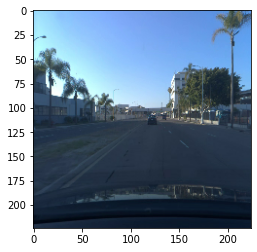

In [ ]:
#Process images

def read_image(path, targets): 
    file = tf.io.read_file(path)
    image = tf.image.decode_jpeg(file, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0
    return (image, targets)

def process_data(df, func):
    paths = df.path.values # The actual file path (ex: './labeled/0/0.0.jpg')
    targets = df[['pitch', 'yaw']].values 
    sub_data = tf.data.Dataset.from_tensor_slices((paths, targets))
    sub_data = sub_data.map(func)
    return sub_data

train_set = process_data(train_df, read_image)
test_set = process_data(test_df, read_image)
val_set = process_data(val_df, read_image)

for x,y in train_set:
    plt.imshow(x)
    print(y)
    break

print(type(train_set))

In [ ]:
# #Create baseline CNN model 
# baseline_CNN = Sequential([
#     Input((224, 224, 3)),
#     Conv2D(4, (3, 3), activation="relu"),
#     Conv2D(8, (3, 3), activation="relu"),
#     Flatten(),
#     Dense(8, activation="relu"),
#     Dense(2, activation=None)
# ])
# baseline_CNN.summary()

# #Fit the model – of all the frames from the five videos, train_set is 80%, val_set is 10%, and test_set is 10%
# baseline_CNN.compile(optimizer=Adam(), loss="mse", metrics=['mse'])
# baseline_CNN.fit(train_set.batch(64), validation_data=val_set.batch(64), epochs=10)

# #Evaluate the model on the test data
# print("\nEVALUATE THE MODEL ON OUR TEST SET:")
# baseline_CNN.evaluate(test_set.batch(64))

In [ ]:
#Create resnetv2 transfer learning model
resnetv2_model = resnet_v2.ResNet50V2(weights="imagenet", input_shape=(224,224,3), pooling='avg', include_top=False)
resnetv2_model.trainable = False

resnet_trained = Sequential([
    resnetv2_model,
    Dense(8, activation="relu"), #Add two new layers to predict pitch and yaw
    Dense(2, activation=None)
])
resnet_trained.summary()

#Fit the model – of all the frames from the five videos, train_set is 80%, val_set is 10%, and test_set is 10%
resnet_trained.compile(optimizer=Adam(), loss="mse", metrics=['mse'])
resnet_trained.fit(train_set.batch(64), validation_data=val_set.batch(64), epochs=10)

#Evaluate the model on the test data
print("\nEVALUATE THE MODEL ON OUR TEST SET:")
resnet_trained.evaluate(test_set.batch(64))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense_15 (Dense)             (None, 8)                 16392     
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 18        
Total params: 23,581,210
Trainable params: 16,410
Non-trainable params: 23,564,800
_________________________________________________________________
Epoch 1/10
64/64 [==============================] - 28s 387ms/step - loss: 0.1050 - mse: 0.1050 - val_loss: 0.0432 - val_mse: 0.0432
Epoch 2/10
64/64 [==============================] - 24s 372ms/step - loss: 0.0294 - mse: 0.0294 - val_loss: 0.0260 - val_mse: 0.0260
Epoch 3/10
64/64 [==============================] - 24s 369ms/step - loss: 0.0196 - mse: 0.0196 - val

[0.009180562570691109, 0.009180562570691109]

In [ ]:
#Choose which model to create predictions for all videos
model_used = resnet_trained

#Use trained CNN model to make new predictions on the labeled data
predictions = {}
for i in range(0,5):
    vid_df = frames_df[frames_df['video_number'] == i]
    vid_set = process_data(vid_df, read_image)
    vid_predictions = model_used.predict(vid_set.batch(64))

    #Use the same frames_scaler to reverse the scale of our pitch and yaw values to get raw predictions
    vid_predictions = frames_scaler.inverse_transform(vid_predictions)
    predictions[i] = vid_predictions

Below is the error calculation that's used in the eval.py script provided by comma.ai. 

In [ ]:
#Determine the overall error score on all videos
def get_mse(gt, test):
  test = np.nan_to_num(test)
  return np.mean(np.nanmean((gt - test)**2, axis=0))

zero_mses = []
mses = []

for i in range(0,5):
    gt = np.loadtxt('./labeled/' + str(i) + '.txt')
    gt = gt[~np.isnan(gt).any(axis=1)]
    zero_mses.append(get_mse(gt, np.zeros_like(gt)))

    test = predictions[i]
    mses.append(get_mse(gt, test))

print(zero_mses)
print(mses)

percent_err_vs_all_zeros = 100*np.mean(mses)/np.mean(zero_mses)
print(f'YOUR ERROR SCORE IS {percent_err_vs_all_zeros:.2f}% (lower is better)')

[0.0010893988518668619, 0.0019336403049261283, 0.0020448864035897915, 0.001045721310362713, 0.0014742302095689548]
[0.0001117552020730164, 3.715734554682755e-05, 0.00010044776172393848, 0.00036416063451943253, 0.0002643825523380294]
YOUR ERROR SCORE IS 11.57% (lower is better)
